In [3]:
%matplotlib widget
import os, re
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.utils import make_grid
import torch.nn.functional as F
import copy

import lightly
from lightly.data import LightlyDataset
from lightly.data import ImageCollateFunction
from lightly.models.modules import BarlowTwinsProjectionHead
from lightly.loss import BarlowTwinsLoss

from lightly.data import DINOCollateFunction
from lightly.loss import DINOLoss
from lightly.models.modules import DINOProjectionHead
from lightly.models.utils import deactivate_requires_grad
from lightly.models.utils import update_momentum

from avalanche.models import SimpleCNN

from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import pandas as pd
from PIL import Image
import cv2
from sklearn.manifold import TSNE

import datasets
from datasets.wrgbd import WRGBD
from datasets.coil100 import Coil100Dataset
from avalanche.benchmarks.datasets import CORe50Dataset
import importlib

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
root_dir = '/home/ehajizad/ss_learning/neuromorphic-continual-learning'
device = "cuda" if torch.cuda.is_available() else "cpu"

In [21]:
importlib.reload(datasets.wrgbd)
from datasets.wrgbd import WRGBD
from datasets.utils import SquarePad


# now use it as the replacement of transforms.Pad class
transform=transforms.Compose([
    SquarePad(),
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

dataset_dir = '/home/ehajizad/datasets/rgbd-dataset'
dataset = WRGBD(root_dir = dataset_dir, transform=transform, read_target_lists=False, all_data=True)
n_obj_per_cat = np.array(dataset.n_obj_per_cat)

# dataset.write_target_lists_to_file()

plate
7 object are loaded
camera
10 object are loaded
bell_pepper
16 object are loaded
food_bag
24 object are loaded
potato
30 object are loaded
notebook
35 object are loaded
bowl
41 object are loaded
toothbrush
46 object are loaded
onion
52 object are loaded
calculator
57 object are loaded
food_can
71 object are loaded
banana
75 object are loaded
food_box
87 object are loaded
water_bottle
96 object are loaded
pear
102 object are loaded
stapler
110 object are loaded
coffee_mug
118 object are loaded
lime
122 object are loaded
marker
131 object are loaded
orange
135 object are loaded
rubber_eraser
139 object are loaded
pitcher
142 object are loaded
comb
146 object are loaded
cereal_box
151 object are loaded
cell_phone
156 object are loaded
hand_towel
161 object are loaded
shampoo
167 object are loaded
cap
171 object are loaded
mushroom
174 object are loaded
greens
178 object are loaded
ball
185 object are loaded
kleenex
190 object are loaded
tomato
198 object are loaded
lightbulb
202 obj

In [10]:
def show_batch(dl, batch_size=12):
    nrow=12
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=nrow, ncol=int(batch_size/nrow)).permute(1, 2, 0))
        plt.tight_layout()
        break


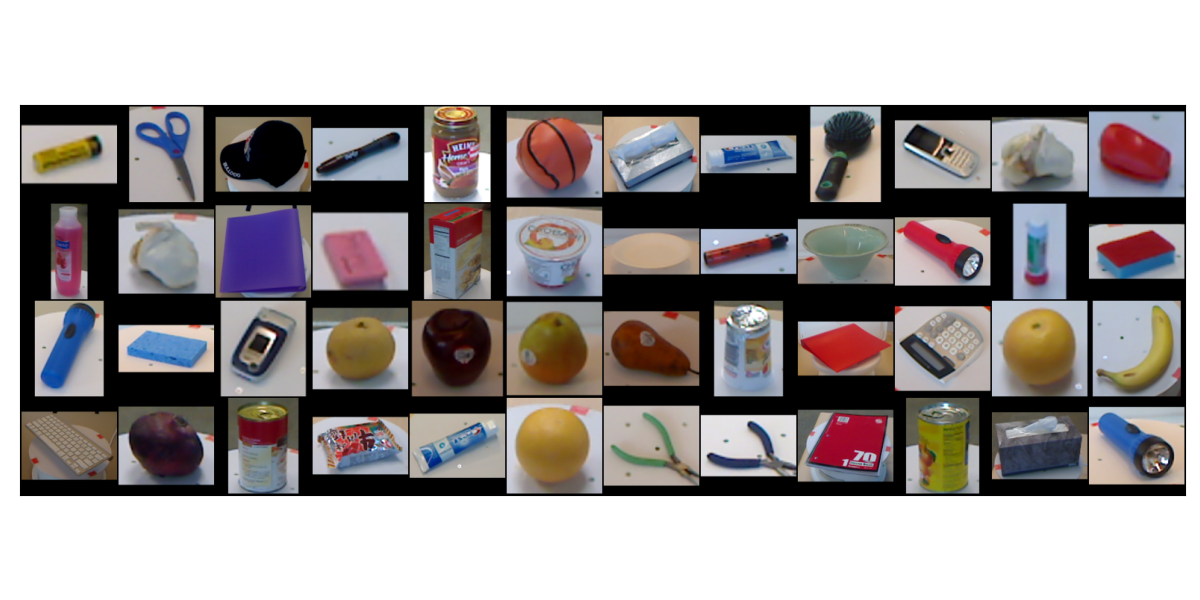

In [11]:
from torch.utils.data import Dataset, DataLoader, random_split
batch_size = 48
feat_ext_dl = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
show_batch(feat_ext_dl)

In [7]:
class DINO(torch.nn.Module):
    def __init__(self, backbone, input_dim):
        super().__init__()
        self.student_backbone = backbone
        self.student_head = DINOProjectionHead(input_dim, 512, 64, 2048, freeze_last_layer=1)
        self.teacher_backbone = copy.deepcopy(backbone)
        self.teacher_head = DINOProjectionHead(input_dim, 512, 64, 2048)
        deactivate_requires_grad(self.teacher_backbone)
        deactivate_requires_grad(self.teacher_head)
    
    def forward(self, x):
        y = self.student_backbone(x).flatten(start_dim=1)
        z = self.student_head(y)
        return z

    def forward_teacher(self, x):
        y = self.teacher_backbone(x).flatten(start_dim=1)
        z = self.teacher_head(y)
        return z

In [8]:
feat_ext = torch.hub.load('facebookresearch/dino:main', 'dino_vits8', pretrained=True)

feat_ext = feat_ext.to(device)

Using cache found in /home/ehajizad/.cache/torch/hub/facebookresearch_dino_main


In [9]:
# model_name = "core50_simsiam_resnet9"


# feat_ext.load_state_dict(torch.load(
#         root_dir+"/models/"+model_name+".pth",
#         map_location=device))

# feat_ext.eval()
# print("Model loeaded")

Model loeaded


In [23]:
from torchvision import models
from torchinfo import summary
# conv_feat_ext = feat_ext#[0:-1]
# conv_feat_ext = feat_ext
conv_feat_ext = nn.Sequential(*list(feat_ext.children())[:2],*list(feat_ext.children())[:-2][2][:-6])
conv_feat_ext.eval()
summary(conv_feat_ext, (1,3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 64, 384]              --
├─PatchEmbed: 1-1                        [1, 64, 384]              --
│    └─Conv2d: 2-1                       [1, 384, 8, 8]            74,112
├─Dropout: 1-2                           [1, 64, 384]              --
├─Block: 1-3                             [1, 64, 384]              --
│    └─LayerNorm: 2-2                    [1, 64, 384]              768
│    └─Attention: 2-3                    [1, 64, 384]              --
│    │    └─Linear: 3-1                  [1, 64, 1152]             443,520
│    │    └─Dropout: 3-2                 [1, 6, 64, 64]            --
│    │    └─Linear: 3-3                  [1, 64, 384]              147,840
│    │    └─Dropout: 3-4                 [1, 64, 384]              --
│    └─Identity: 2-4                     [1, 64, 384]              --
│    └─LayerNorm: 2-5                    [1, 64, 384]              768

In [26]:
embeddings = []
labels = []

dataset_dir = '/home/ehajizad/datasets/rgbd-dataset'
dataset = WRGBD(root_dir = dataset_dir, transform=transform, read_target_lists=True, obj_level=True, all_data=True)
all_obj_labels = dataset.obj_targets
all_cat_labels = dataset.cat_targets
all_view_targets = dataset.view_targets

ss_inds = list(range(0,len(dataset.targets),30))
dataset = torch.utils.data.Subset(dataset, ss_inds)

feat_ext_dl = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4)

conv_feat_ext.eval()
with torch.no_grad():
    for batch in feat_ext_dl:
        image, label = batch 
        # print("Before data:", torch.cuda.memory_allocated(device)/1e9)
        image, label = image.to(device), label.to(device)
        emb = conv_feat_ext(image).flatten(start_dim=1)
        embeddings.append(emb)
        labels.append(label)
        
embeddings = torch.cat(embeddings, 0)
embeddings = np.array(torch.Tensor.cpu(embeddings))

labels = torch.cat(labels)
labels = np.array(torch.Tensor.cpu(labels))

All target lists are loaded


In [27]:
ss_obj_labels = np.array(all_obj_labels)[ss_inds]
ss_cat_labels = np.array(all_cat_labels)[ss_inds]
ss_view_targets = np.array(all_view_targets)[ss_inds]

In [28]:
embeddings.shape

(6931, 98304)

In [185]:
sorted_inds = np.argsort(labels)

y_sorted = labels[sorted_inds]
x_sorted = embeddings[sorted_inds]

In [186]:
y = y_sorted.copy()
X = x_sorted.copy()

In [187]:
unique, counts = np.unique(labels, return_counts=True)
np.mean(counts)

140.48648648648648

In [145]:

X_tsne = TSNE(n_components=2, learning_rate='auto', n_jobs=-1, n_iter_without_progress=100, verbose=2,
                 init='pca', perplexity=163, n_iter=2500, metric='cosine').fit_transform(X)

[t-SNE] Computing 490 nearest neighbors...
[t-SNE] Indexed 8317 samples in 0.006s...
[t-SNE] Computed neighbors for 8317 samples in 1.983s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8317
[t-SNE] Computed conditional probabilities for sample 2000 / 8317
[t-SNE] Computed conditional probabilities for sample 3000 / 8317
[t-SNE] Computed conditional probabilities for sample 4000 / 8317
[t-SNE] Computed conditional probabilities for sample 5000 / 8317
[t-SNE] Computed conditional probabilities for sample 6000 / 8317
[t-SNE] Computed conditional probabilities for sample 7000 / 8317
[t-SNE] Computed conditional probabilities for sample 8000 / 8317
[t-SNE] Computed conditional probabilities for sample 8317 / 8317
[t-SNE] Mean sigma: 0.008518
[t-SNE] Computed conditional probabilities in 1.170s


/home/ehajizad/ss_learning/ssl_env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Iteration 50: error = 65.4381638, gradient norm = 0.0009088 (50 iterations in 1.414s)
[t-SNE] Iteration 100: error = 65.2124329, gradient norm = 0.0004507 (50 iterations in 1.599s)
[t-SNE] Iteration 150: error = 65.1260223, gradient norm = 0.0002208 (50 iterations in 1.650s)
[t-SNE] Iteration 200: error = 65.0965729, gradient norm = 0.0001219 (50 iterations in 1.391s)
[t-SNE] Iteration 250: error = 65.0817642, gradient norm = 0.0000700 (50 iterations in 1.551s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.081764
[t-SNE] Iteration 300: error = 1.6388317, gradient norm = 0.0011527 (50 iterations in 1.521s)
[t-SNE] Iteration 350: error = 1.3494794, gradient norm = 0.0004327 (50 iterations in 1.211s)
[t-SNE] Iteration 400: error = 1.2424793, gradient norm = 0.0002373 (50 iterations in 1.468s)
[t-SNE] Iteration 450: error = 1.1864376, gradient norm = 0.0001687 (50 iterations in 1.264s)
[t-SNE] Iteration 500: error = 1.1524631, gradient norm = 0.0001154 (50 

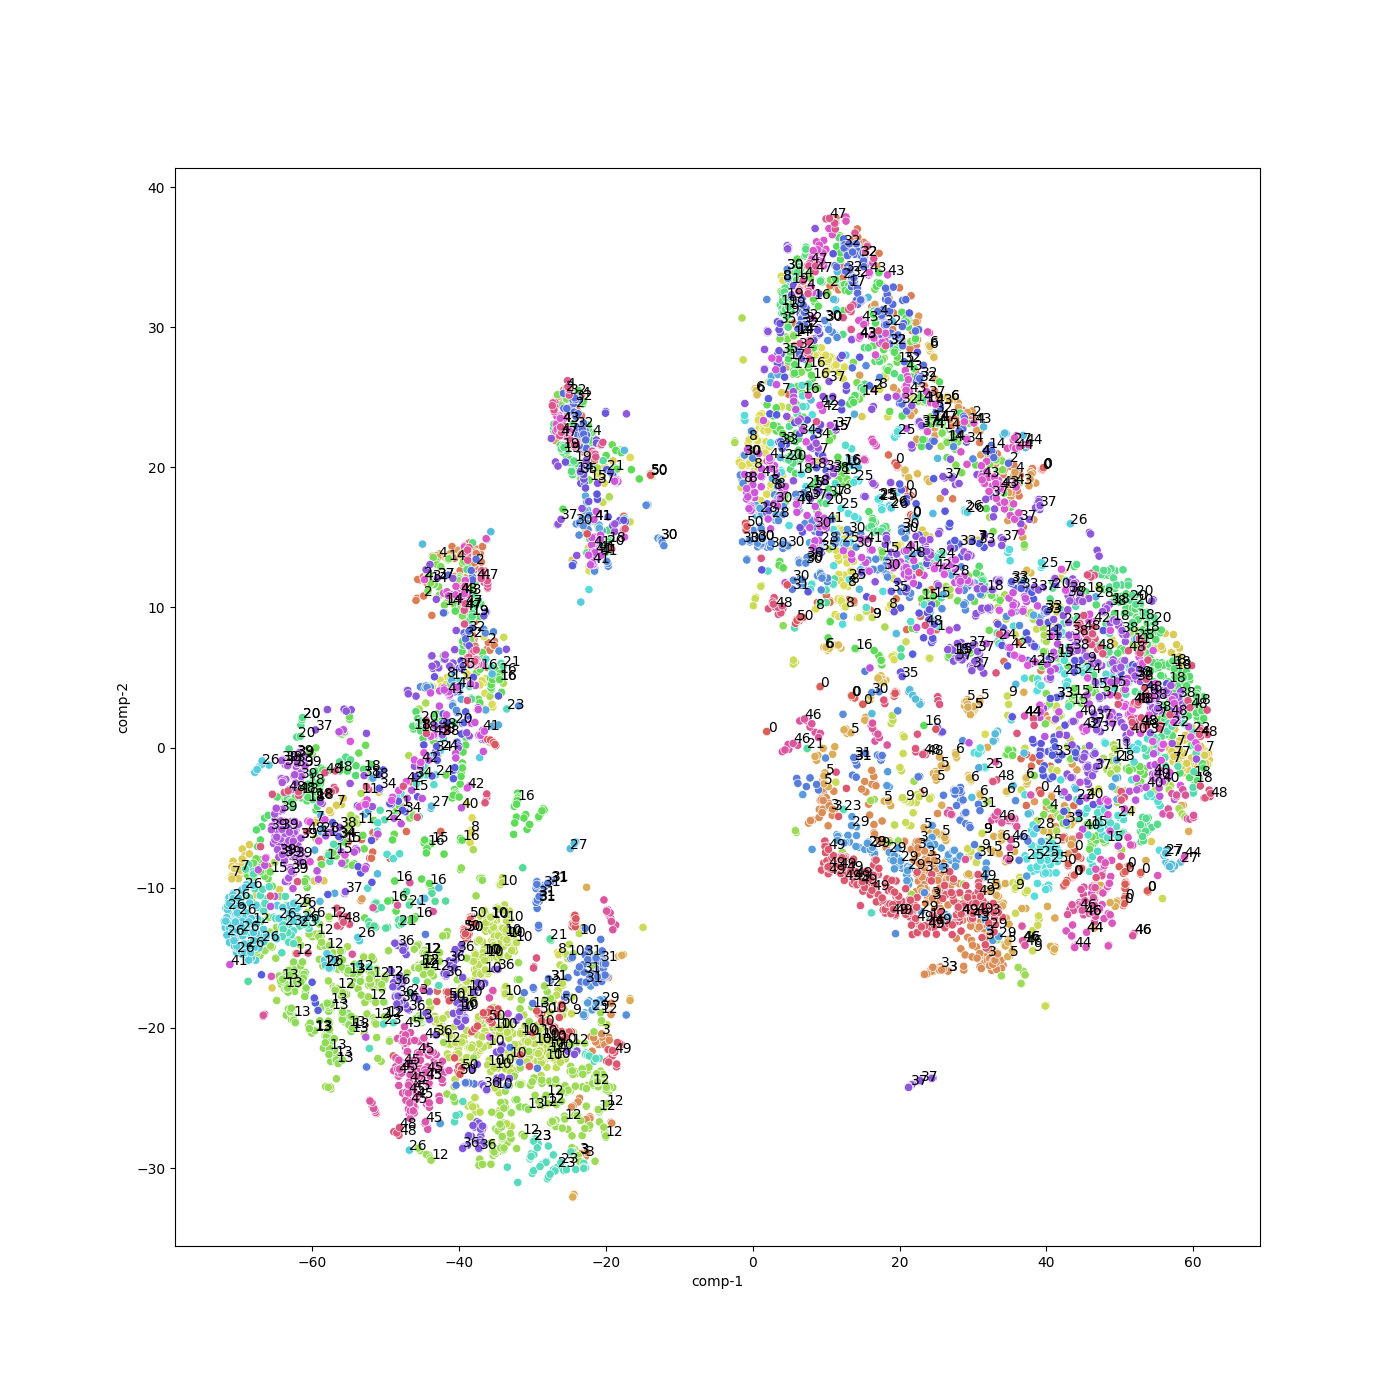

In [150]:
import seaborn as sns
n_objects = len(np.unique(labels))
df = pd.DataFrame()
df["y"] = y
df["comp-1"] = X_tsne[:,0]
df["comp-2"] = X_tsne[:,1]
plt.figure(figsize=(14,14))
ax = sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", n_objects),legend=False,
                data=df)

a = pd.concat({'x': df["comp-1"], 'y': df["comp-2"], 'label': df["y"]}, axis=1)
a = a.sample(frac=0.1, replace=True, random_state=1)
for i, point in a.iterrows():
    ax.text(point['x']+.02, point['y'], str(point['label'].astype(int)))

In [13]:
###----------------------------------------------------------###
###-----Offline Object Categorization Exepriment-------------###

X = embeddings.copy()
y = ss_cat_labels.copy()

# Leave one instance from each category for testing, in the categorization experiments

# Choose single object instance from each category as test instance
cum_obj_count = [0] + np.cumsum(n_obj_per_cat).tolist()

accs = []
for t in range(10):
    test_obj_ind = []
    for i in range(len(n_obj_per_cat)):
        test_obj_ind.append(np.random.choice(np.arange(cum_obj_count[i], cum_obj_count[i+1])))

    test_inds = np.where(np.isin(ss_obj_labels,test_obj_ind))[0]
    train_inds = np.delete(np.arange(len(y)), test_inds)

    X_train = X[train_inds,:]
    X_test = X[test_inds,:]
    y_train = y[train_inds]
    y_test = y[test_inds]
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, shuffle=True) # 80% training and 20% test

    clf = svm.LinearSVC(max_iter=2000)
    # clf = svm.LinearSVC(max_iter=10000)
    clf.fit(X_train, y_train)

    # y_pred_train=clf.predict(X_train)
    y_pred_test=clf.predict(X_test)

    # Model Accuracy: how often is the classifier correct?
    # print("Train Accuracy:",metrics.accuracy_score(y_train, y_pred_train))
    acc = metrics.accuracy_score(y_test, y_pred_test)
    print("Test Accuracy:", acc)
    accs.append(acc)

Test Accuracy: 0.7233396035306033
Test Accuracy: 0.7174731961750217


/home/ehajizad/ss_learning/ssl_env/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Test Accuracy: 0.7374749498997996


/home/ehajizad/ss_learning/ssl_env/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Test Accuracy: 0.743377001455604


/home/ehajizad/ss_learning/ssl_env/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Test Accuracy: 0.7110163468372424
Test Accuracy: 0.7416931522681306


/home/ehajizad/ss_learning/ssl_env/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Test Accuracy: 0.7128467153284671
Test Accuracy: 0.6912751677852349


/home/ehajizad/ss_learning/ssl_env/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Test Accuracy: 0.7183178902352103
Test Accuracy: 0.727794900532362


/home/ehajizad/ss_learning/ssl_env/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [14]:
mean_acc = np.round(100*np.mean(accs),1)
std_acc = np.round(100*np.std(accs),1)
print("Offline Object Categorization Exepriment accuracies:", str(mean_acc), u"\u00B1", str(std_acc))


Offline Object Categorization Exepriment accuracies: 72.2 ± 1.5


In [ ]:
###----------------------------------------------------------###
###-----Offline Object Identifiation Exepriment--------------###

X = embeddings.copy()
y = ss_obj_labels.copy()

# Leave one (elevation) viewing angle out of three (30, 45, 60) in the object identification experiments

test_inds = np.where(ss_view_targets==2)[0]
train_inds = np.delete(np.arange(len(y)), test_inds)

X_train = X[train_inds,:]
X_test = X[test_inds,:]
y_train = y[train_inds]
y_test = y[test_inds]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, shuffle=True) # 80% training and 20% test

clf = svm.LinearSVC(max_iter=3000)
# clf = svm.LinearSVC(max_iter=10000)
clf.fit(X_train, y_train)

# y_pred_train=clf.predict(X_train)
y_pred_test=clf.predict(X_test)

# Model Accuracy: how often is the classifier correct?
# print("Train Accuracy:",metrics.accuracy_score(y_train, y_pred_train))
acc = metrics.accuracy_score(y_test, y_pred_test)
print("Test Accuracy:", acc)


In [ ]:
print("Test Accuracy:", acc)

In [35]:
from sklearn.utils import shuffle
n_repeat = 10
bmu_metrics = ["euclidean", "dot_product", "cosine"]
accs = np.zeros(shape=(len(bmu_metrics),n_repeat))
n_neighbors = 1

X = embeddings.copy()
# y = ss_cat_labels.copy()
y = ss_obj_labels.copy()

# Leave one instance from each category for testing, in the categorization experiments
# Choose single object instance from each category as test instance
cum_obj_count = [0] + np.cumsum(n_obj_per_cat).tolist()


for bm, bmu_metric in enumerate(bmu_metrics): 
    for r in range(n_repeat):
        
#         test_obj_ind = []
#         for i in range(len(n_obj_per_cat)):
#             test_obj_ind.append(np.random.choice(np.arange(cum_obj_count[i], cum_obj_count[i+1])))

#         test_inds = np.where(np.isin(ss_obj_labels,test_obj_ind))[0]
#         train_inds = np.delete(np.arange(len(y)), test_inds)
        
        # Leave one (elevation) viewing angle out of three (30, 45, 60) in the object identification experiments

        test_inds = np.where(ss_view_targets==2)[0]
        train_inds = np.delete(np.arange(len(y)), test_inds)

        X_train = X[train_inds,:]
        X_test = X[test_inds,:]
        y_train = y[train_inds]
        y_test = y[test_inds]
        
        if bmu_metric != "dot_product":
            knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric=bmu_metric)
            knn.fit(X_train, y_train)
            y_pred_test=knn.predict(X_test)
            
        else:
            sim_X_train = np.matmul(X_train,X_train.T)
            sim_X_test = np.matmul(X_test,X_train.T)

#             sim_X_train[sim_X_train<dp_min] = dp_min
#             sim_X_train[sim_X_train>dp_max] = dp_max

#             sim_X_test[sim_X_test<dp_min] = dp_min
#             sim_X_test[sim_X_test>dp_max] = dp_max

            sim_X_train = np.max(sim_X_train) - sim_X_train
            sim_X_test = np.max(sim_X_test) - sim_X_test
            
            knn = KNeighborsClassifier(n_neighbors=1, algorithm="brute",  metric="precomputed")
            knn.fit(sim_X_train, y_train)

            y_pred_test=knn.predict(sim_X_test)

        # Model Accuracy: how often is the classifier correct?
        acc = metrics.accuracy_score(y_test, y_pred_test)        
        accs[bm, r] = acc

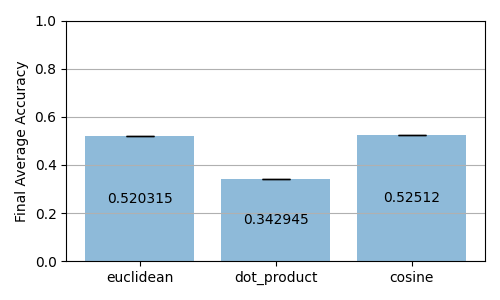

In [36]:
x_pos = np.arange(len(bmu_metrics))
CTEs = np.mean(accs, axis=1)
error = np.std(accs, axis=1)

# Build the plot
fig, ax = plt.subplots(figsize=(5,3))
bars = ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Final Average Accuracy')
ax.set_xticks(x_pos)
ax.set_xticklabels(bmu_metrics)
ax.yaxis.grid(True)
ax.set_ylim([0,1])
ax.bar_label(bars, label_type='center')


# Save the figure and show
plt.tight_layout()
plt.show()
# print(CTEs)

In [35]:
clf = svm.LinearSVC(max_iter=2000)
# clf = svm.LinearSVC(max_iter=10000)
clf.fit(X_train, y_train)

# y_pred_train=clf.predict(X_train)
y_pred_test=clf.predict(X_test)

# Model Accuracy: how often is the classifier correct?
# print("Train Accuracy:",metrics.accuracy_score(y_train, y_pred_train))
print("Test Accuracy:",metrics.accuracy_score(y_test, y_pred_test))

Test Accuracy: 0.7881673881673882


In [33]:
nn = np.arange(1,20,2)
accs_cos = []
accs_euc = []

X = embeddings.copy()
y = ss_cat_labels.copy()

# Leave one instance from each category for testing, in the categorization experiments
# Choose single object instance from each category as test instance
cum_obj_count = [0] + np.cumsum(n_obj_per_cat).tolist()

test_obj_ind = []
for i in range(len(n_obj_per_cat)):
    test_obj_ind.append(np.random.choice(np.arange(cum_obj_count[i], cum_obj_count[i+1])))

test_inds = np.where(np.isin(ss_obj_labels,test_obj_ind))[0]
train_inds = np.delete(np.arange(len(y)), test_inds)

X_train = X[train_inds,:]
X_test = X[test_inds,:]
y_train = y[train_inds]
y_test = y[test_inds]
    
for i in nn:
    knn = KNeighborsClassifier(n_neighbors=i, metric="cosine")
    knn.fit(X_train, y_train)

    y_pred_test=knn.predict(X_test)

    # Model Accuracy: how often is the classifier correct?
    acc = metrics.accuracy_score(y_test, y_pred_test)
    accs_cos.append(acc)
    
    knn = KNeighborsClassifier(n_neighbors=i, metric="euclidean")
    knn.fit(X_train, y_train)

    y_pred_test=knn.predict(X_test)

    # Model Accuracy: how often is the classifier correct?
    acc = metrics.accuracy_score(y_test, y_pred_test)
    accs_euc.append(acc)
    # print("Test Accuracy:", acc)

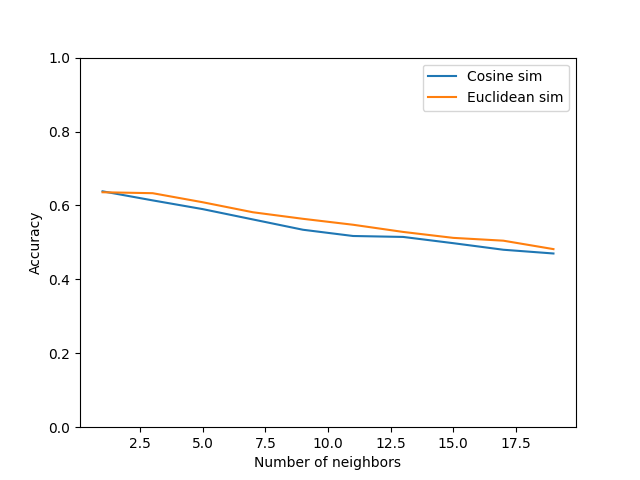

In [34]:
plt.figure()
plt.plot(nn, accs_cos)
plt.plot(nn, accs_euc)
plt.legend(["Cosine sim", "Euclidean sim"])
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy")
plt.ylim([0,1])

plt.show()